## 0. Download Dataset

In [1]:
!gdown --id 1L99FSzloXGQsmc-OwsVKggvQNF9niN2M
!unzip -q maestro_small.zip


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1L99FSzloXGQsmc-OwsVKggvQNF9niN2M
From (redirected): https://drive.google.com/uc?id=1L99FSzloXGQsmc-OwsVKggvQNF9niN2M&confirm=t&uuid=f367aea2-a463-43db-bfbe-678e2616f1bb
To: /content/maestro_small.zip
100% 1.14G/1.14G [00:17<00:00, 64.9MB/s]


In [2]:
!pip install mido pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 9.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=ddaae90c9346a1b949e5265121e9b1c9bddad0660635147e75d9b6b5bd548bc4
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


## 1. Preprocess Data

In [6]:
import json
json_path = '/content/data/data.json'

with open(json_path, 'r') as f:
 meta = json.load(f)

In [20]:
data_dict = meta[59]
midi_fn = data_dict['midi_filename']
audio_fn = data_dict['audio_filename']
data_dict


{'canonical_composer': 'Claude Debussy',
 'canonical_title': 'Preludes, Book II, III - La puerta del vino',
 'split': 'train',
 'year': 2013,
 'midi_filename': '2013/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--2.midi',
 'audio_filename': '2013/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--2.wav',
 'duration': 179.321401875}

In [27]:
import IPython.display as ipd
from pathlib import Path

data_dir = Path('data/')
flac_fn = (data_dir / audio_fn).with_suffix('.flac')
ipd.Audio(flac_fn)

In [99]:
import torchaudio
y, sr = torchaudio.load(flac_fn)

In [101]:
y.shape

torch.Size([1, 2885138])

In [42]:
from mido import Message, MidiFile, MidiTrack, MetaMessage

midi_abs_fn = data_dir / midi_fn
assert midi_abs_fn.exists()

midi_obj = MidiFile(midi_abs_fn)
for message in midi_obj.merged_track[:20]:
  print(message)

MetaMessage('set_tempo', tempo=500000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('track_name', name='7.8.13 Group 1', time=0)
program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=127 time=0
control_change channel=0 control=67 value=0 time=0
note_on channel=0 note=44 velocity=99 time=735
note_on channel=0 note=37 velocity=115 time=58
control_change channel=0 control=64 value=72 time=63
control_change channel=0 control=64 value=0 time=15
control_change channel=0 control=64 value=50 time=137
control_change channel=0 control=64 value=67 time=14
control_change channel=0 control=64 value=76 time=15
control_change channel=0 control=64 value=93 time=16
control_change channel=0 control=64 value=127 time=15
note_on channel=0 note=44 velocity=0 time=22
note_on channel=0 note=52 velocity=82 time=366
control_change channel=0 control=64 value=67 time=15
control_change channe

In [79]:
set([message.control for message in midi_obj.merged_track if message.type=='control_change'])

{64, 67}

In [44]:
message.type

'note_on'

In [52]:
cur_time = 0
entire_notes = []
temp_notes = []

for message in midi_obj.merged_track:
  cur_time += message.time / 768
  if message.type == 'note_on':
    if message.velocity > 0:
      temp_notes.append({'pitch': message.note, 'onset': cur_time, 'velocity': message.velocity})
    else: # message.velocity ==0  -> note offset
      delete_idxs = []
      for idx, prev_note in enumerate(temp_notes):
        if prev_note['pitch'] == message.note:
          prev_note['offset'] = cur_time
          delete_idxs.append(idx)
          entire_notes.append(prev_note)
      for idx in reversed(delete_idxs):
        temp_notes.pop(idx)

entire_notes

[{'pitch': 44,
  'onset': 0.95703125,
  'velocity': 99,
  'offset': 1.4192708333333333},
 {'pitch': 45,
  'onset': 1.9583333333333333,
  'velocity': 106,
  'offset': 2.00390625},
 {'pitch': 52,
  'onset': 1.8958333333333333,
  'velocity': 82,
  'offset': 2.0182291666666665},
 {'pitch': 57,
  'onset': 2.325520833333333,
  'velocity': 76,
  'offset': 2.42578125},
 {'pitch': 37,
  'onset': 1.0325520833333333,
  'velocity': 115,
  'offset': 2.4270833333333335},
 {'pitch': 50, 'onset': 2.3828125, 'velocity': 107, 'offset': 2.43359375},
 {'pitch': 45,
  'onset': 2.734375,
  'velocity': 89,
  'offset': 2.8333333333333335},
 {'pitch': 52,
  'onset': 2.6953125,
  'velocity': 73,
  'offset': 3.1640625000000004},
 {'pitch': 44, 'onset': 2.796875, 'velocity': 89, 'offset': 3.223958333333334},
 {'pitch': 45,
  'onset': 3.7200520833333344,
  'velocity': 95,
  'offset': 3.7695312500000013},
 {'pitch': 52,
  'onset': 3.667968750000001,
  'velocity': 87,
  'offset': 3.790364583333335},
 {'pitch': 57,
 

In [91]:
# this time consider sustain pedal


def parse_notes_from_midi_obj(midi_obj):

  cur_time = 0
  cur_pedal = 0
  entire_notes = []
  temp_notes = []
  sus_notes = []
  pedal_threshold = 64

  for message in midi_obj.merged_track:
    cur_time += message.time / 768
    if message.type == 'note_on':
      if message.velocity > 0:
        temp_notes.append({'pitch': message.note, 'onset': cur_time, 'velocity': message.velocity})
      else: # message.velocity ==0  -> note offset
        delete_idxs = []
        for idx, prev_note in enumerate(temp_notes):
          if prev_note['pitch'] == message.note:
            delete_idxs.append(idx)

            # check pedal threhsold
            if cur_pedal < pedal_threshold:
              prev_note['offset'] = cur_time
              entire_notes.append(prev_note)
            else:
              sus_notes.append(prev_note)
        for idx in reversed(delete_idxs):
          temp_notes.pop(idx)
    elif message.type == 'control_change' and message.control == 64:
      cur_pedal = message.value
      if cur_pedal < pedal_threshold:
        for note in sus_notes:
          note['offset'] = cur_time
        entire_notes += sus_notes
        sus_notes = []
  return entire_notes
entire_notes = parse_notes_from_midi_obj(midi_obj)

In [64]:
# convert notes to piano roll

def time_to_frame(time_in_sec, hop_length_in_ms=32):
  return int(time_in_sec // (hop_length_in_ms / 1000))

time_to_frame(entire_notes[0]['onset']), entire_notes[0]['onset']

(29, 0.95703125)

In [94]:
import torch

list_of_notes = entire_notes
def notes_to_roll(list_of_notes, hop_length_in_ms=32):
  last_note_end = max( [note['offset'] for note in list_of_notes[-10:]])
  num_frame = time_to_frame(last_note_end)
  roll = torch.zeros(88, num_frame, dtype=torch.int8)

  for note in list_of_notes:
    pitch = note['pitch']
    on_frame = time_to_frame(note['onset'])
    off_frame = time_to_frame(note['offset'])
    off_frame = max(on_frame+1, off_frame)
    roll[pitch-21, on_frame:off_frame] = 1
  return roll

roll = notes_to_roll(entire_notes)

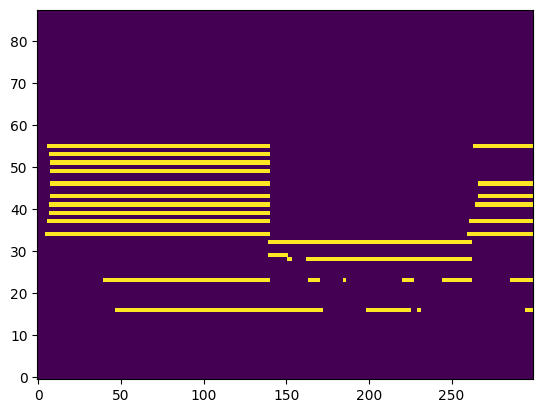

In [93]:
import matplotlib.pyplot as plt


plt.imshow(roll[:, 1200:1500], aspect='auto', origin='lower', interpolation='nearest')

In [69]:
180 / 0.032

5625.0

In [142]:
from tqdm.auto import tqdm
import torchaudio
import random

class Dataset:
  def __init__(self, data_dir='data/', meta_fn='/content/data/data.json', slice_len=15):
    self.dir = Path(data_dir)

    with open(meta_fn, 'r') as f:
      self.meta = json.load(f)
    self.meta = self.meta[:50]
    self.rolls = self._prepare_roll()
    self.audios = self._load_audio()
    self.slice_len = slice_len # in second
    self.sr = 16000

  def _prepare_roll(self):
    rolls = []
    for sample in tqdm(self.meta):
      midi_fn = sample['midi_filename']
      midi_abs_fn = self.dir / midi_fn
      midi_obj = MidiFile(midi_abs_fn)
      notes = parse_notes_from_midi_obj(midi_obj)
      roll = notes_to_roll(notes)
      rolls.append(roll)
    return rolls

  def _load_audio(self):
    audios = []
    for sample in tqdm(self.meta):
      audio_fn = sample['audio_filename']
      audio_abs_fn = (self.dir / audio_fn).with_suffix('.flac')
      y, _ = torchaudio.load(audio_abs_fn)
      audios.append(y.squeeze())
    return audios

  def __len__(self):
    return len(self.meta)

  def __getitem__(self, idx):
    audio = self.audios[idx]
    roll = self.rolls[idx]

    seg_start = random.randint(0, len(audio) - self.sr * self.slice_len -1)
    seg_end = seg_start + self.sr * self.slice_len

    frame_start = seg_start // 512 # divide by hop_length in sample
    frame_end = frame_start + (self.slice_len * self.sr) // 512

    sliced_roll = roll[:, frame_start:frame_end]
    if sliced_roll.shape[1] != (self.slice_len * self.sr) // 512  :
      dummy_roll = torch.zeros(88, (self.slice_len * self.sr) // 512)
      dummy_roll[:, :sliced_roll.shape[1]] = sliced_roll
      sliced_roll = dummy_roll

    return audio[seg_start : seg_end], sliced_roll


dataset = Dataset()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [114]:
audio, roll = dataset[0]
audio.shape, roll.shape

(torch.Size([240000]), torch.Size([88, 468]))

In [110]:
ipd.Audio(audio, rate=16000)

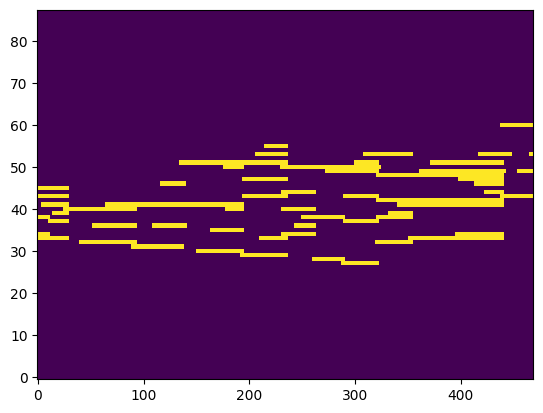

In [111]:
plt.imshow(roll, aspect='auto', origin='lower', interpolation='nearest')

In [118]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=5)

batch = next(iter(train_loader))
audio, label = batch
audio.shape, label.shape

(torch.Size([5, 240000]), torch.Size([5, 88, 468]))

## 2. Model

In [127]:
import torch.nn as nn

class SpecConverter(nn.Module):
  def __init__(self):
    super().__init__()
    self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=352)
    self.db = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db(self.mel(x)) / 80

converter = SpecConverter()
out = converter(audio)

In [141]:
class Transcriber(nn.Module):
  def __init__(self):
    super().__init__()
    self.spec = SpecConverter()

    self.conv_stack = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3,3), padding=(1,1)),
        nn.ReLU(),
        nn.MaxPool2d((2, 1)),
        nn.Conv2d(32, 32, kernel_size=(3,3), padding=(1,1)),
        nn.ReLU(),
        nn.MaxPool2d((2, 1)),
        nn.Conv2d(32, 32, kernel_size=(3,3), padding=(1,1)),
        nn.ReLU(),
        nn.MaxPool2d((2, 1))
    )
    self.linear = nn.Linear(32*44, 88)

  def forward(self, x):
    spec = self.spec(x).unsqueeze(1)
    conv_out = self.conv_stack(spec)
    conv_out = conv_out.flatten(1,2).permute(0, 2, 1) # N x T x H
    return self.linear(conv_out)

model = Transcriber()
model(audio).shape

torch.Size([5, 469, 88])

## 3. Training

In [148]:
def bce_loss(pred, target):
  return -(target * torch.log(pred + 1e-8) + (1-target) * torch.log(1-pred + 1e-8)).mean()

model = Transcriber()
optimizer = torch.optim.Adam(model.parameters())
train_loader = DataLoader(dataset, batch_size=16)
model.to('cuda')

loss_record = []

for epoch in tqdm(range(30)):
  for batch in train_loader:
    audio, label = batch
    pred = model(audio.cuda())
    pred = pred.sigmoid().permute(0, 2, 1) # N x 88 x T
    pred = pred[..., :-1]
    loss = bce_loss(pred, label.to('cuda').to(torch.float32))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

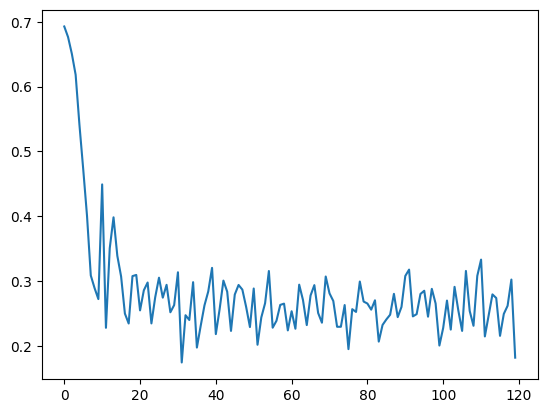

In [149]:
plt.plot(loss_record)